## Project Description

This project provides a model for habitat suitability for S. Nutans (Indiangrass) on 3 different national grasslands, and analyzes the affect of climate change on the distribution of suitable habitat within thos national grasslands.

Step 1: Load all relevant libraries

In [13]:
from glob import glob
import requests
import shutil
import os
import wget 

import earthpy as et
import earthpy.plot as ep
import earthpy.appeears as eaap
import folium
import geopandas as gpd
import geoviews as gv
import geoviews.tile_sources as gts
import hvplot.pandas
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.plot import show
import rioxarray as rxr
import rioxarray.merge as rxm
import xarray as xr
from xrspatial import aspect
from xrspatial import slope

data_dir = os.path.join(et.io.HOME, et.io.DATA_NAME)
grasslands_dir = os.path.join(data_dir, 'grassland_units')
vars_dir = os.path.join(data_dir, 'variables')
soil_dir = os.path.join(vars_dir, 'theta_r_layer')

for a_dir in [grasslands_dir, vars_dir, soil_dir]:
    if not os.path.exists(a_dir):
        os.makedirs(a_dir)

Step 2: Load the National Grassland Units

The three National Grasslands chosen for analysis are the Crooked River National Grassland in the high desert of Central OR, the Little Missouri National Grassland, the largest in the country, in western North Dakota, and the Sheyenne National Grassland in south-eastern North Dakota. 

Data Source and Citation:
    The data comes from the US Department of Agriculture Geodata Library, the USDA manages the national grasslands. 

In [14]:
# Downloading and saving the grasslands shapefile to the grasslands directory
grasslands_path = os.path.join(grasslands_dir, 'S_USA.NationalGrassland.shp')
if not os.path.exists(grasslands_path):
    gpd.read_file("https://data.fs.usda.gov/geodata/edw/edw_resources/shp/S_USA.NationalGrassland.zip").to_file(grasslands_path)

# Building a GeoDataFrame from the USFS grasslands shapefile
grasslands_gdf = (gpd
                  .read_file(grasslands_path)
                  .set_index('GRASSLANDN'))

# Subsetting the Little Missouri and Crooked River NG's
lm_cr_s_ng_gdf = (
    grasslands_gdf
    .loc[['Little Missouri National Grassland', 'Crooked River National Grassland', 'Sheyenne National Grassland']]
)
lmng_utm = 32614
lmng_gdf = lm_cr_s_ng_gdf.loc[['Little Missouri National Grassland']]
crng_utm = 32613
crng_gdf = lm_cr_s_ng_gdf.loc[['Crooked River National Grassland']]
sng_utm = 32611
sng_gdf = lm_cr_s_ng_gdf.loc[['Sheyenne National Grassland']]


Step 3: Downloading a series of variable layers in order to build the suitability model

DataSource: The Polaris Dataset was collected by the USGS and is a soil survey that includes a number of soil variables at 30m resolution.

In [15]:
# Load the soil residual water content (theta_r) variable raster layer from the Polaris Dataset
def polaris_theta_r_download(min_lat, max_lat, min_lon, max_lon, file_name):
    """
    Parameters
    ==========
    min_lat : integer
        The minimum single latitude which bounds the desired sudy area
    min_lon : integer
        The minimum single longitue which bounds the desired study area

    Returns
    =======
    DataArray of raster data for the desired study variable bounded by a single degree of latitue and longitude
    """
    soil_fctn_path = os.path.join(soil_dir, file_name)
    if not os.path.exists(soil_fctn_path):
        lat_range = list(range(min_lat, max_lat + 1))
        lon_range = list(range(max_lon, min_lon + 1))
        polaris_das = []
        for lat in lat_range:
            for lon in lon_range:
                polaris_url_format = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES"
                                      "/v1.0/theta_r/mean/100_200/lat{min_lat}{max_lat}"
                                      "_lon{min_lon}{max_lon}.tif")

                polaris_url = polaris_url_format.format(
                min_lat=lat, min_lon=lon-1, max_lat=lat+1, max_lon=lon
                )

                print(polaris_url)

                polaris_das.append(rxr.open_rasterio(polaris_url, masked=True).squeeze())
        rxm.merge_arrays(polaris_das).rio.to_raster(soil_fctn_path, driver='GTiff')

    return rxr.open_rasterio(soil_fctn_path)


In [16]:
def raster_clip_reproject(da, utm, gdf):
    """
    Parameters
    ==========
    da : DataArray
        Raster array to be clipped and reprojected into the UTM CRS
    utm : integer
        The correct epsg for the utm reprojection
    gdf : DeoDataFrame
        The geodatafrma whose geometry and bounds will be used to clip the raster data

    Returns
    =======
    The raster data array that has been clipped and reprojected
    """
    # gdf = gdf.to_crs(utm)
    da_adj = (da
              .rio.clip_box(*gdf.total_bounds)
              .rio.reproject(utm)   
    )
    return da_adj

In [17]:
lmng_soil_da = (polaris_theta_r_download(46, 48, -102, -104, 'lmng-soil.tif')
                .rio.clip_box(*lmng_gdf.total_bounds)
                .rio.reproject(lmng_utm)
)

crng_soil_da = (polaris_theta_r_download(44, 45, -121, -122, 'crng-soil.tif')
                .rio.clip_box(*crng_gdf.total_bounds)
                .rio.reproject(crng_utm)
)

sng_soil_da = (polaris_theta_r_download(46, 47, -97, -98, 'sng-soil.tif')
               .rio.clip_box(*sng_gdf.total_bounds)
               .rio.reproject(sng_utm)
)


In [18]:
# lmng_soil_da.hvplot(x='x', y='y') * lmng_gdf.hvplot()

# crng_soil_da.hvplot(x='x', y='y') * crng_gdf.hvplot()

# sng_soil_da.hvplot(x='x', y='y') * sng_gdf.hvplot()

In [19]:
# Creating a for loop to replace the above function
# List of national grasslands with associated latitude and longitude
# national_grasslands_minlatlon = [
#     {"name": "Little Missouri National Grassland", "latitude": 47, "longitude": -103},
#     {"name": "Crooked River National Grassland", "latitude": 44, "longitude": -121},
#     {"name": "Sheyenne National Grassland", "latitude": 46, "longitude": -97},
# ]

# # Loop through each national grassland
# for grassland in national_grasslands_minlatlon:
#     name = grassland["name"]
#     min_lat, min_lon = grassland["latitude"], grassland["longitude"]
#     max_lat, max_lon = min_lat+1, min_lon+1

#     polaris_url_format = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES"
#                           "/v1.0/theta_r/mean/100_200/lat{min_lat}{max_lat}"
#                           "_lon{min_lon}{max_lon}.tif")

#     polaris_url = polaris_url_format.format(
#     min_lat=min_lat, min_lon=min_lon, max_lat=max_lat, max_lon=max_lon
#     )

#     print(polaris_url)

#     data_array = rxr.open_rasterio(polaris_url, masked=True).squeeze()

#     # Print information about the data array
#     print(f"DataArray for {name}:")
#     print(data_array)

#     # Optionally, save the DataArray as a variable
#     locals()[f"{name.lower()}_data"] = data_array



Data Source: The elevation and topographical data comes from the earthdata library of NASA, and is a product of the shuttle radar topography mission.

[NASA Earthdata](https://www.earthdata.nasa.gov/sensors/srtm)

In [20]:
# Load elevation data from the SRTM dataset through the APPEEARS API

def srtm_download(file_name, gdf):
    """
    Parameters
    ==========
    file_name : str
        Desired file name for the DataArray when it is saved in the earthpy downloads directory
    gdf : GeoDatafram
        The dataframe conatining a single geometry for the APPEEARS downloader to indentify 

    Returns
    =======
    DataArray of the elevations raster data for the selected national grassland geometry
    """
    srtm_downloader = eaap.AppeearsDownloader(
    ea_dir=data_dir,
    download_key=file_name,
    product='SRTMGL1_NC.003',
    layer='SRTMGL1_DEM',
    start_date='02-11-2000',
    end_date='02-21-2000',
    polygon=gdf
    )
    if not os.path.exists(os.path.join(data_dir, file_name)):
        srtm_downloader.download_files(cache=True)

    srtm_filepaths = glob(os.path.join(srtm_downloader.data_dir,
                                       'SRTMGL1_NC.003*',
                                       '*.tif'
                                       ))
    return rxm.merge_arrays([rxr.open_rasterio(srtm_filepaths, masked=True).squeeze() for srtm_filepaths in srtm_filepaths])



In [21]:
lmng_elev_da = (srtm_download('little-missouri-ng-srtm', lmng_gdf)
                .rio.clip_box(*lmng_gdf.total_bounds)
)
crng_elev_da = (srtm_download('crooked-river-ng-srtm', crng_gdf)
                .rio.clip_box(*crng_gdf.total_bounds)
)
sng_elev_da = (srtm_download('sheyenne-ng-srtm', sng_gdf)
               .rio.clip_box(*sng_gdf.total_bounds)
)

lmng_elev_crp_da = lmng_elev_da.rio.reproject_match(lmng_soil_da)
crng_elev_crp_da = crng_elev_da.rio.reproject_match(crng_soil_da)
sng_elev_crp_da = sng_elev_da.rio.reproject_match(sng_soil_da)



Data Source: The MacaV2 Data is a product of NOAA and was access through a third pary website.

In [22]:
# Load and save climate variable raster layers from the MACAv2 Dataset

def precip_download(year):
    """
    Parameters
    ==========
    year : int
        This is the year for which monhtly precipitation data will be downloaded

    Returns
    =======
        The function returns a DataArray of monthly precipitation data for the specified year
    """
    
    maca_url_format = ("http://thredds.northwestknowledge.net:8080/thredds/ncss/"
              "agg_macav2metdata_pr_CCSM4_r6i1p1_rcp85_2006_2099_CONUS_monthly"
              ".nc?var=precipitation&disableLLSubset=on"
              "&disableProjSubset=on&horizStride=1"
              "&time_start={year}-01-15T00%3A00%3A00Z"
              "&time_end={year}-12-15T00%3A00%3A00Z"
              "&timeStride=1&accept=netcdf"
    )
    maca_url = maca_url_format.format(year=year)
    maca_response = requests.get(maca_url)
    with open('maca.nc', 'wb') as maca_file:
        maca_file.write(maca_response.content)
    maca_ds = xr.open_dataset('maca.nc')
    maca_ds = maca_ds.assign_coords(lon=maca_ds.lon-360)
    precip_da = maca_ds.precipitation
    precip_da = precip_da.rio.write_crs(4326, inplace=True)
    precip_da = precip_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    return precip_da


In [23]:
precip_2010 = precip_download(2010)
print(precip_2010.max())

<xarray.DataArray 'precipitation' ()>
array(1070.5494, dtype=float32)
Coordinates:
    crs      int64 0


In [24]:
# maca_url = ("http://thredds.northwestknowledge.net:8080/thredds/ncss/"
#               "agg_macav2metdata_pr_CCSM4_r6i1p1_rcp45_2006_2099_CONUS_monthly"
#               ".nc?var=precipitation&disableLLSubset=on"
#               "&disableProjSubset=on&horizStride=1"
#               "&time_start=2010-01-15T00%3A00%3A00Z"
#               "&time_end=2010-02-15T00%3A00%3A00Z"
#               "&timeStride=1&accept=netcdf"
# )

# maca_response = requests.get(maca_url)
# with open('maca.nc', 'wb') as maca_file:
#     maca_file.write(maca_response.content)
# maca_ds = xr.open_dataset('maca.nc')
# maca_ds = maca_ds.assign_coords(lon=maca_ds.lon-360)
# precip_da = maca_ds.precipitation
# precip_da = precip_da.rio.write_crs("epsg:4326", inplace=True)
# precip_da = precip_da.rio.set_spatial_dims('lon', 'lat', inplace=True)


In [25]:
# precip_da.rio.clip_box(*lmng_gdf.total_bounds).mean('time').hvplot()

# lmng_precip_crp_da = raster_clip_reproject(precip_da, lmng_utm, lmng_gdf)
# crng_precip_crp_da = raster_clip_reproject(precip_da, crng_utm, crng_gdf)
# sng_precip_crp_da = raster_clip_reproject(precip_da, sng_utm, sng_gdf)

In [26]:
precip_2010 = precip_download(2010)

lmng_precip_2010_mean_crp = (precip_2010.rio.clip_box(*lmng_gdf.total_bounds)
                                 .rio.reproject_match(lmng_soil_da)
                                 .mean('time')
)

crng_precip_2010_mean_crp = (precip_2010.rio.clip_box(*crng_gdf.total_bounds)
                                 .rio.reproject_match(crng_soil_da)
                                 .mean('time')
)                                 

sng_precip_2010_mean_crp = (precip_2010.rio.clip_box(*sng_gdf.total_bounds)
                                .rio.reproject_match(sng_soil_da)
                                .mean('time')
)    

In [27]:
precip_2060 = precip_download(2060)

lmng_precip_2060_mean_crp = (precip_2060.rio.clip_box(*lmng_gdf.total_bounds)
                                 .rio.reproject_match(lmng_soil_da)
                                 .mean('time')
)

crng_precip_2060_mean_crp = (precip_2060.rio.clip_box(*crng_gdf.total_bounds)
                                 .rio.reproject_match(crng_soil_da)
                                 .mean('time')
)

sng_precip_2060_mean_crp = (precip_2060.rio.clip_box(*sng_gdf.total_bounds)
                                .rio.reproject_match(sng_soil_da)
                                .mean('time')
) 

In [28]:
# precip_2010 = precip_download(2010)
# precip_2060 = precip_download(2060)

# lmng_precip_2010_mean_crp = (precip_2010.rio.clip_box(*lmng_gdf.total_bounds)
#                                  .rio.reproject_match(lmng_soil_da)
#                                  .mean('time')
# )
# lmng_precip_2060_mean_crp = (precip_2060.rio.clip_box(*lmng_gdf.total_bounds)
#                                  .rio.reproject_match(lmng_soil_da)
#                                  .mean('time')
# )

# crng_precip_2010_mean_crp = (precip_2010.rio.clip_box(*crng_gdf.total_bounds)
#                                  .rio.reproject_match(crng_soil_da)
#                                  .mean('time')
# )                                 
# crng_precip_2060_mean_crp = (precip_2060.rio.clip_box(*crng_gdf.total_bounds)
#                                  .rio.reproject_match(crng_soil_da)
#                                  .mean('time')
# )

# sng_precip_2010_mean_crp = (precip_2010.rio.clip_box(*sng_gdf.total_bounds)
#                                 .rio.reproject_match(sng_soil_da)
#                                 .mean('time')
# )                                
# sng_precip_2060_mean_crp = (precip_2060.rio.clip_box(*sng_gdf.total_bounds)
#                                 .rio.reproject_match(sng_soil_da)
#                                 .mean('time')
# )                                

Step 4: calculating slope and aspect

In [29]:
lmng_slope_da = slope(lmng_elev_crp_da)
crng_slope_da = slope(crng_elev_crp_da)
sng_slope_da = slope(sng_elev_crp_da)

In [30]:
lmng_aspect_da = aspect(lmng_elev_crp_da)
crng_aspect_da = aspect(crng_elev_crp_da)
sng_aspect_da = aspect(sng_elev_crp_da)

Step 5: Building the suitability model.

The model is a fuzzy logic model in which each raster variable is assigned a value between 1 and 0 according to its suitability for the growth of S. Nutans. The layers are then multiplied together to create a sinlge raster layer correlated to habitat suitability for S. Nutans. The layer is annalyzed for historical and projected precipitation data as the climate changes between 2010 and 2060.

In [31]:
# For each of the variables, the raster values will be assigned a value from 0 to 1 based on the suitability for S. Nutans

# Starting with the soil variable, residual soil moisture content (theta_r). 
# According to Penn Stateand the USDA, S. Nutans grows best in deep, well-drained soil. 
# https://extension.psu.edu/warm-season-grasses-and-wildlife

# I will thus associate lower theta_r values with a suitability model closer to 1 using the following normalization equation: 

def soil_normalize(da):
    """
    Parameters
    ==========
    da : DataArray
        This is the dataarray of residual soil moisture values to be normalized between 0 and 1

    Returns
    =======
        A dataarray of normalized values between 0 and 1 regarding the suitability of the soil variable for S. Nutans
    """
    min_val = da.min()
    max_val = da.max()

    
    normalized_da = (da - min_val) / (max_val - min_val) 

    return normalized_da


In [32]:
lmng_soil_normalized = soil_normalize(lmng_soil_da)
crng_soil_normalized = soil_normalize(crng_soil_da)
sng_soil_normalized = soil_normalize(sng_soil_da)

In [33]:
# For the elevation Data, S. Nutans prefers to grow in full sun or very limited shade,
# accordingly, I will asign values close to 1 for south facing aspects and closer to 0 for
# north facing slopes.

def aspect_normalize(da):
    """
    Parameters
    ==========
    da : DataArray
        This is the dataarray of topographical slope-aspect values to be normalized between 0 and 1

    Returns
    =======
        A dataarray of normalized values between 0 and 1 regarding the suitability of the aspect variable for S. Nutans
    """
    distance = np.abs(da - 180)
    out_da = 1 - (distance / 180)
        
    return out_da



In [34]:
lmng_aspect_normalized = aspect_normalize(lmng_aspect_da)
crng_aspect_normalized = aspect_normalize(crng_aspect_da)
sng_aspect_normalized = aspect_normalize(sng_aspect_da)

In [35]:
# The prime annual precipitation for S. Nutans in 28-114 cm, the precipitation raster array is displayed as a monthly mean in mm.
# The data will need to be annualized, and converted to cm before normalized 
# on a scale of 0 to 1, with values closer to 1 corellated to values falling 
# closer to the center of the suitanility band of 28-114 cm at 71 cm.
# https://www.nrcs.usda.gov/plantmaterials/etpmcpg13196.pdf

def precip_normalized(da):
    """
    Parameters
    ==========
    da : DataArray
        This is the dataarray of monthly precipitation values to be normalized between 0 and 1

    Returns
    =======
        A dataarray of normalized values between 0 and 1 regarding the suitability of the precipitation variable for S. Nutans
    """
    cm_da = da /10
    annual_cm_da = cm_da * 12
    normalized_da = 1-(np.abs(71-annual_cm_da)/71) ** 2



    # min_val = annual_cm_da.min()
    # max_val = annual_cm_da.max()
    # min_dif = (71-annual_cm_da).min()
    # if (max_val - 71) > (71 - min_val):
    #     normalized_da = 1 - (annual_cm_da - (71-min_dif) / (max_val - (71-min_dif)))
    # else:
    #     normalized_da = 1 - ((annual_cm_da - (71-min_dif)) / (min_val - (71-min_dif)))

    return normalized_da


In [36]:
# Scenario 1: 2010
lmng_precip_2010_normal = precip_normalized(lmng_precip_2010_mean_crp)
crng_precip_2010_normal = precip_normalized(crng_precip_2010_mean_crp)
sng_precip_2010_normal = precip_normalized(sng_precip_2010_mean_crp)

# Scenrio 2: 2060
lmng_precip_2060_normal = precip_normalized(lmng_precip_2060_mean_crp)
crng_precip_2060_normal = precip_normalized(crng_precip_2060_mean_crp)
sng_precip_2060_normal = precip_normalized(sng_precip_2060_mean_crp)

Step 6: Run and display the fuzzy logic model

Sheyenne National Grassland

In [37]:
# Sheyenne National Grassland

sng_model_layer_2010 = sng_soil_normalized * sng_aspect_normalized * sng_precip_2010_normal 
sng_model_layer_2060 = sng_soil_normalized * sng_aspect_normalized * sng_precip_2060_normal 

2010 Sheyenne National Grassland habitat suitability plot

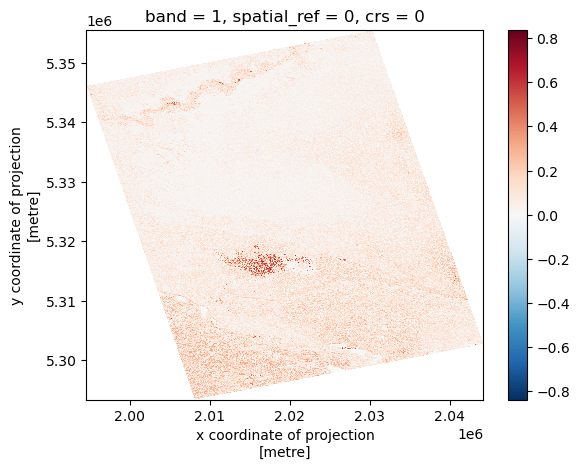

In [38]:
sng_model_layer_2010.plot()

2060 Sheyenne National Grassland habitat suitability plot

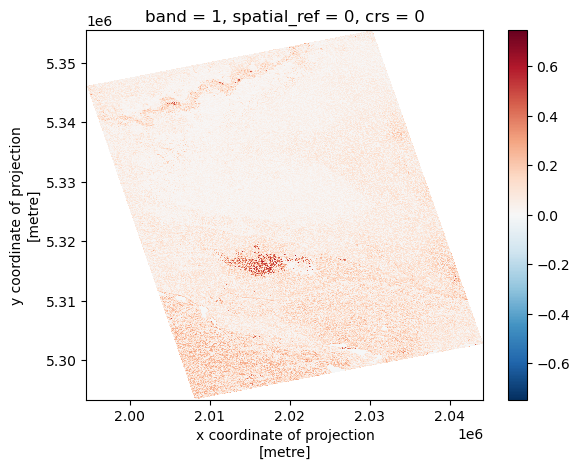

In [39]:
sng_model_layer_2060.plot()

The plot showing change in habitat suitability between 2010 and 2060 in the Sheyenne National Grassland

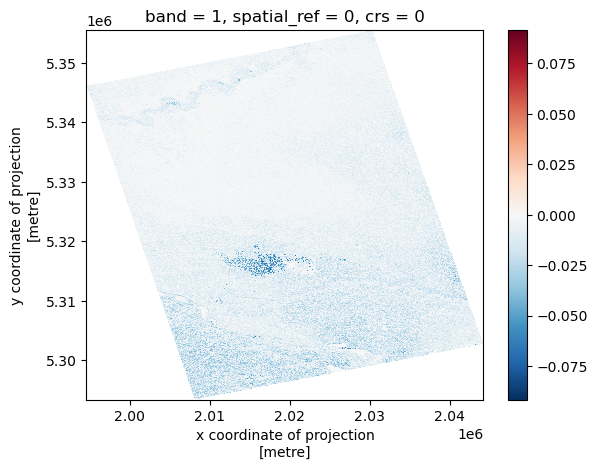

In [40]:
sng_climate_effects = sng_model_layer_2060 - sng_model_layer_2010

sng_climate_effects.plot()

Crooked River National Grassland

In [41]:
# Crooked River National Grassland

crng_model_layer_2010 = crng_soil_normalized * crng_aspect_normalized * crng_precip_2010_normal 
crng_model_layer_2060 = crng_soil_normalized * crng_aspect_normalized * crng_precip_2060_normal 

2010 Crooked River National Grassland habitat suitability plot

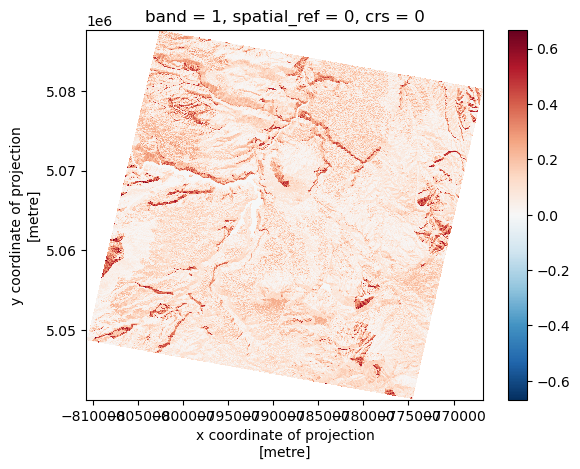

In [42]:
crng_model_layer_2010.plot()

2060 Crooked River National Grassland habitat suitability plot

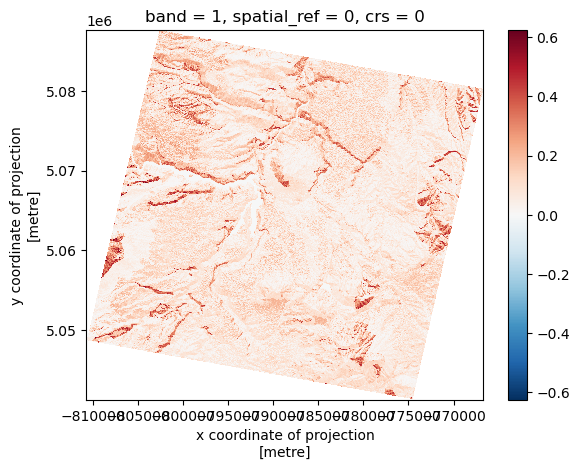

In [43]:
crng_model_layer_2060.plot()

The plot showing change in habitat suitability between 2010 and 2060 in the Crooked River National Grassland

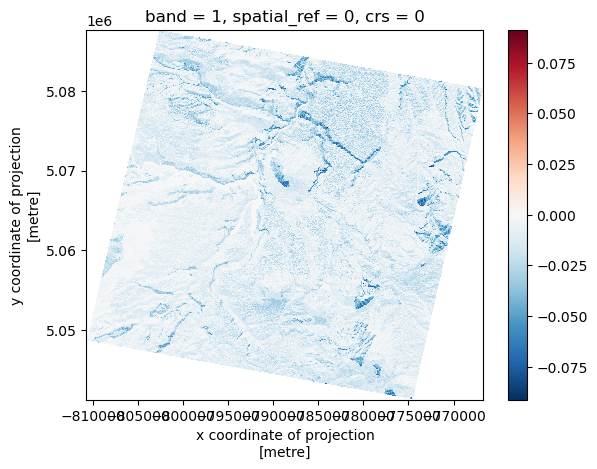

In [44]:
crng_climate_effects = crng_model_layer_2060 - crng_model_layer_2010

crng_climate_effects.plot()

Little Missouri National Grassland

In [45]:
# Little Missouri National Grassland

lmng_model_layer_2010 = lmng_soil_normalized * lmng_aspect_normalized * lmng_precip_2010_normal 
lmng_model_layer_2060 = lmng_soil_normalized * lmng_aspect_normalized * lmng_precip_2060_normal 

2010 Little Missouri National Grassland habitat suitability plot

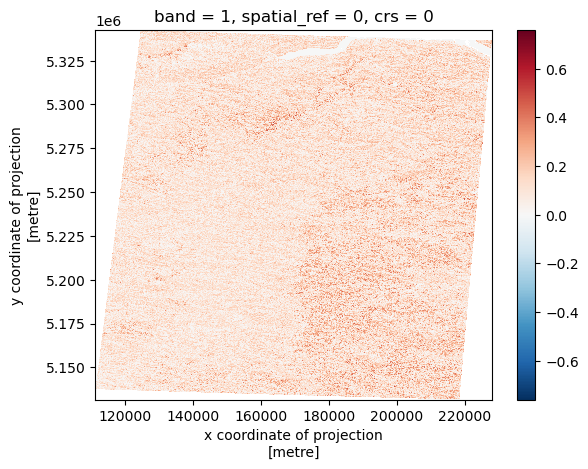

In [46]:
lmng_model_layer_2010.plot()

2060 Little Missouri National Grassland habitat suitability plot

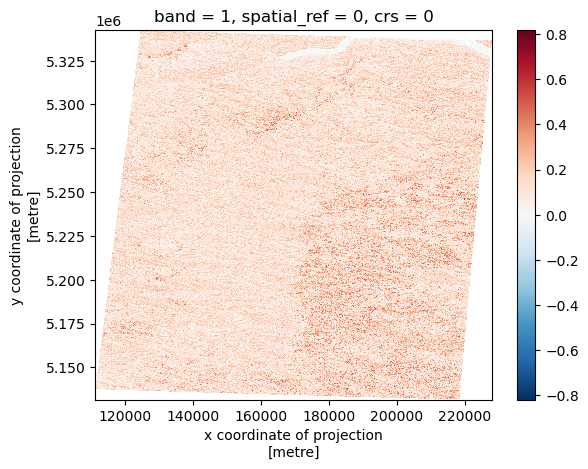

In [47]:
lmng_model_layer_2060.plot()

The plot showing change in habitat suitability between 2010 and 2060 in the Little Missouri National Grassland

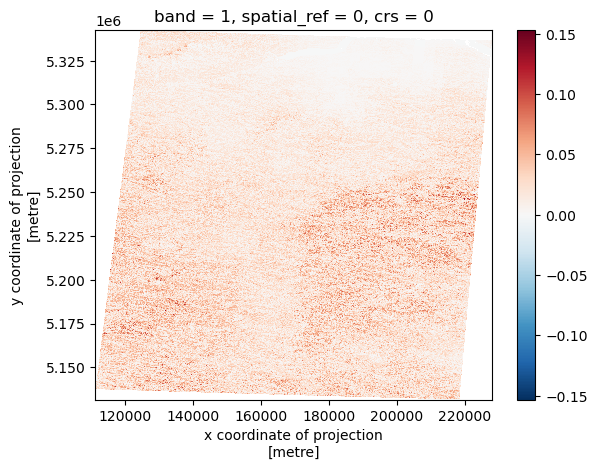

In [48]:
lmng_climate_effects = lmng_model_layer_2060 - lmng_model_layer_2010

lmng_climate_effects.plot()

In [49]:
# import cartopy as ctp
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# sng_bbox = (sng_gdf.to_crs(crs=sng_utm).total_bounds[0],
#             sng_gdf.to_crs(crs=sng_utm).total_bounds[2],
#             sng_gdf.to_crs(crs=sng_utm).total_bounds[1],
#             sng_gdf.to_crs(crs=sng_utm).total_bounds[3]
# )

# sng_bbox = (sng_gdf.total_bounds[0], sng_gdf.total_bounds[2], sng_gdf.total_bounds[1], sng_gdf.total_bounds[3])

# ax = plt.axes(projection=ccrs.UTM(11, southern_hemisphere=False))
# ax.set_extent(sng_bbox)
# ax.stock_img()
# plt.show()
